In [109]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import random as rd

"Données du problème"
delta = 5
a = 50
sigma_2 = 12
obs_index = [0, 20, 40, 60, 80, 100]
disc_index = [i for i in range(101)]
non_obs_index = list(set(disc_index)-set(obs_index))
x_liste = [i * delta for i in range(101)]
depth = np.array([0, -4, -12.8, -1, -6.5, 0])

question 1 : Il s'agit de la loi des grands nombres : elle stipule que si on prend n var $X_{i}$ iid, ayant toutes une espérance finie, alors si on note $S_{n}= \frac{1}{n} * \sum_{k=1}^{n} X_k$ alors $\lim\limits_{n \rightarrow +\infty} E(S_n) = E(X_1)$. Ici, Sn correspondrait à la moyenne empirique des simulations conditionnelles, et E(X1) correspondrait à L*.
question 2 : Voir proba IV page 13-14, où le problème est traité pour le vecteur des Z_i dans lequel les n-k dernières valeurs sont connues. Pour se ramener à ce problème, il faut seulement permuter les éléments de manière à ce que nos éléments $z_{j_{1}}, ....z_{j_{n}}$ se retrouvent à la fin du vecteur.

question 3 : à remplir quand on aura retrouvé la feuille mais en gros si on pose Z = m+ RY, avec Y qui suit la loi normale centrée réduite, alors Z suit la loi N(m, C) avec C = $R * transposée(R)$. 

Question 4 : Le but de l'algorithme est de simuler la longueur totale connaissant $z_{j_{1}}, ....z_{j_{n}}$. Pour cela, on commence par permuter les éléments du vecteur pour que $j_{1}, ..., j_{n}$ se retrouvent en derniers élements du vecteur, comme dans le cours. Pour cela on peut par exemple considérer qu'on étudie pour la suite Z' = $P_{\sigma} * Z$ avec $\sigma$ la permutation associée, il faudra donc considérer la matrice de covariance dans notre nouvelle base. Ensuite, on peut appliquer le résultat de la question 2 et la question 3 : si on note $Z'_{obs} et Z'_{pasobs}$ les sous-vecteurs associés, alors $Z'_{pasobs}$|$Z'_{obs}=Z_{obs_{0}}$ suit la loi Gaussienne d'espérance $m_{pasobs}$ + ...............
Notons l'espérance $\mu$, la matrice de covariance associée C. Pour simuler cette loi, on doit commencer par simuler une loi normale centrée réduite, grace à la proposition page 10 de proba V. Ensuite, on applique la question 3 : on calcule la transformée de Cholesky de C, qu'on appelle R, et on calcule $\mu$+RZ'.
Grace à tout ca on a réussi à simuler Z', il reste juste à multiplier par l'inverse de la matrice de permutation pour obtenir Z, et ensuite à calculer l = $\sum_{k=1}^{p-1} \sqrt{\delta ^{2} + (Z[k+1]-Z[k])^{2}}$. Enfin, en réitérant un certain nombre de fois, la question 1 nous permet d'assurer une approximation de l'espérance L* de la longueur conditionnelle

In [123]:
"""question 1 de la partie pratique"""
def cov(dist, a, V):
    """on distingue le cas d'une distance réelle ou d'une matrice de distances"""
    return V * np.exp(-dist/a)
        
cov(np.array([[1, 1], [2, 2]]), 3, 2)    

array([[1.43306262, 1.43306262],
       [1.02683424, 1.02683424]])

Question 2 : Calculons la matrice de distance : M[i][j] = dist(|$x_{i}-x_{j}$|) = $|i-j| * \delta$ , donc M = $\delta  *(|i-j|)_{1<=i, j <= p}$
Question 3 : Déduisons-en la matrice de covariance de notre problème : 
C = $V *(exp(-\delta*\frac{|i-j|}{a}))_{1<=i, j <= p}$

In [111]:
#Question 2
Mat_dist = np.array([[np.abs(x_liste[i]-x_liste[j]) for j in range(101)] for i in range(101)])
print(Mat_dist)
#Question 3
C = cov(Mat_dist, a, sigma_2)

[[  0   5  10 ... 490 495 500]
 [  5   0   5 ... 485 490 495]
 [ 10   5   0 ... 480 485 490]
 ...
 [490 485 480 ...   0   5  10]
 [495 490 485 ...   5   0   5]
 [500 495 490 ...  10   5   0]]


In [112]:

"""Question 4 : En réalité, ici on ne procède pas exactement comme dans la réponse à la question 4 de la partie théorique, 
où l'on commencait par se ramener à un vecteur dont les dernières composantes sont les observables. Ici, on extrait directement les blocs de la matrice de 
covariance de Z, sans passer par l'étape intermédiaire de permutation : celle-ci est incluse dans le processus. Pour ces programmes, 
on considère (ce qui dans notre exemple est vrai), que obs_index est rangée dans l'ordre croissant"""

def extrac_o_o(C, obs_index):
    """on extrait la matrice des indices observables, qui correspond à CZ dans le cours, 
    soit la sous-matrice en bas à droite de C proba IV page 13"""
    C_o = np.array([[0 for j in range(len(obs_index))]for i in range(len(obs_index))])
    for i in range(len(obs_index)):#on parcourt les indices observables de la matrice
        for j in range(len(obs_index)):
            C_o[i][j] = C[obs_index[i]][obs_index[j]]
    return C_o

def extrac_n_n(C, non_obs_index):
    """Ca correspond à la matrice des indices non observables, qui correspond à CY dans le cours,
    soit la sous-matrice en haut à gauche de C"""
    C_n = np.array([[0 for j in range(len(C)-len(obs_index))]for i in range(len(C)-len(obs_index))])
    for i in range(len(non_obs_index)):#on parcourt les indices non observables de la matrice
        for j in range(len(non_obs_index)):
            C_n[i][j] = C[non_obs_index[i]][non_obs_index[j]]
    return C_n

def extrac_o_n(C, obs_index, non_obs_index):
    """Ca correspond à Czy, soit la matrice en bas à gauche de C, disons la matrice de covariance entre 
    observables et non observables"""
    C_o_n = np.array([[0 for j in range(len(non_obs_index))]for i in range(len(obs_index))])
    for i in range(len(obs_index)):#on parcourt les indices observables de la matrice
        for j in range(len(non_obs_index)):#on parcourt les indices non observables
            C_o_n[i][j] = C[obs_index[i]][non_obs_index[j]]
    return C_o_n


In [113]:
"""questions 5 et 6 il faut utiliser la question 2 théorique et les questions précédentes"""

#Question 5
def E_condi(C, obs_index, non_obs_index, mu, dept):
    """calcul de l'espérance conditionnelle : 
    on applique la formule du cours p 14 proba IV, en continuant l'analogie avec les matrices par bloc extraites """
    C_z = extrac_o_o(C, obs_index)
    C_y = extrac_n_n(C, non_obs_index)
    C_zy = extrac_o_n(C, obs_index, non_obs_index)
    return np.array([mu for i in range(len(non_obs_index))]) + np.linalg.multi_dot([C_zy.T, np.linalg.inv(C_z), dept - np.array([mu for i in range(len(obs_index))])])

#Question 6
def schur_n(C, obs_index, non_obs_index):
    """C dépendant de |xi-xj| uniquement, elle est symétrique, donc C_ys = C_zy.T"""
    C_z = extrac_o_o(C, obs_index)
    C_y = extrac_n_n(C, non_obs_index)
    C_zy = extrac_o_n(C, obs_index, non_obs_index)
    return C_y - np.linalg.multi_dot([C_zy.T, np.linalg.inv(C_z), C_zy])

def Var_condi(Ccond, i, non_obs_index):
    """i est l'indice de notre position dans Z et non Z', on commence donc par
    calculer la position j qu'a i sur la diagonale de la matrice conditionnelle, puis on calcule sa variance conditionnelle"""
    for j in range(len(non_obs_index)):
        if non_obs_index[j] == i : #on parcourt les non observables jusqu'à trouver l'indice correspondant à i
            return Ccond[j][j]
    return 0 # si ce n'est pas dans les non observables, c'est observable, donc on retourne 0

Text(0.5, 0, 'indice')

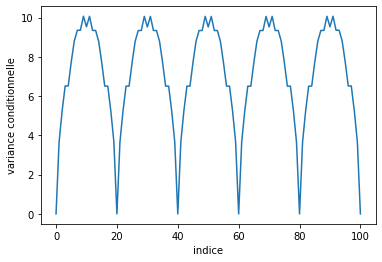

In [124]:

CSy = schur_n(C, obs_index, non_obs_index)
mu = -5
E_cond = E_condi(C, obs_index, non_obs_index, mu, depth)
A = [Var_condi(CSy, i, non_obs_index) for i in disc_index]
plt.plot(disc_index, A)
plt.ylabel("variance conditionnelle")
plt.xlabel("indice")


En tracant, on observe la periodicité de la variance en fonction de i, ce qui est logique étant donné la répartition des indices des observables, cette variance parait tendre vers 0 à chaque fois que l'on s'approche des indices observables. C'est parfaitement logique : plus le point est proche d'un point observable, plus on pourra estimer précisément sa profondeur et donc plus l'étalement probabiliste, et donc la variance, sera faible. 

In [115]:

def tirage(C, obs_index, non_obs_index, E):
    """ici on écrit le programme qui permet de simuler le tirage conditionnel, grace aux questions 2 et 3, 
    on utilise notamment le fait qu'un vecteur aux composantes normales centrées réduites est normal centré réduit"""
    CSy = np.around(schur_n(C, obs_index, non_obs_index), 6) # c'est la matrice de covariance de la loi conditionnelle
    R = np.linalg.cholesky(CSy)
    #simulation de la loi normale centrée réduite 
    U = np.array([rd.random() for i in range(len(C[0])-len(obs_index))])
    V = np.array([rd.random() for i in range(len(C[0])-len(obs_index))])
    norm = np.array([np.sqrt(-2 * np.log(U[i])) * np.cos(2 * np.pi * V[i]) for i in range(len(U))]) # le vecteur normal centré réduit
    return E + R.dot(norm) #qui suit bien une loi gaussienne d'espérance E et de matrice de covariance C
    

Text(0.5, 0, 'indice')

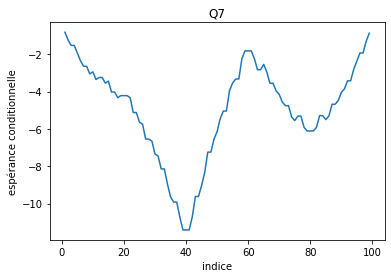

In [116]:
E_cond_tot = list(np.copy(E_cond))
"""avec notre matrice de covariance, on ne peut pas répondre à la Q7, car elle n'est pas définie positive (cf cellule d'après).
On trace donc uniquement l'espérance conditionnelle en fonction de l'indice"""
for i in range(len(obs_index)) : 
    E_cond_tot.insert(obs_index[i], depth[i])
plt.plot(non_obs_index, E_cond)
plt.title("Q7")
plt.ylabel("espérance conditionnelle")
plt.xlabel("indice")


[-3.213131571263745, -1.1060497158083293, -1.3726998375508113, -1.0819762668143649, -2.2654489096682866, -1.9091174413435827, -2.7450476896472122, -2.090896889439353, -3.79239868302541, -2.636054785682476, -2.977994145228915, -3.413104080401981, -3.30862074267373, -5.101503929099509, -4.094800673610621, -4.499533875432365, -3.5722975053163863, -5.263956473900193, -3.7730617225752723, -5.319188366040145, -2.8767685269117127, -3.7096654550853865, -4.837956992913112, -5.729353134885897, -5.320228862081446, -6.324900536584422, -4.791646278677875, -7.684157487736252, -7.4896130895722886, -9.293362500655737, -7.591989225483349, -9.172292341628033, -8.398941484026844, -10.389590193052834, -9.964162699774247, -9.73667949302773, -10.100346959621676, -11.078730257922333, -11.69525612663191, -10.735970461779269, -11.094706101618888, -7.469887367961448, -8.845609613257592, -5.977416868054698, -5.906504676699217, -6.964309758972094, -5.8597378149442605, -6.3373194606433465, -4.24997463684862, -6.12

Text(0.5, 0, 'indice')

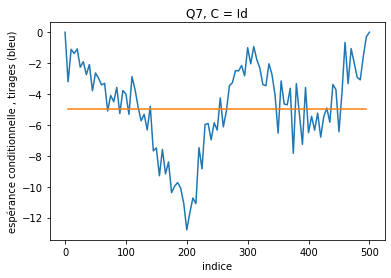

In [117]:

"""on trace ensuite l'altitude en fonction de x"""

#Z = tirage(C, obs_index, non_obs_index, E_cond)
"""problème à régler ici, car avec cette forme de C, CSy n'est pas définie positive et on ne peut donc
pas lui appliquer la transformation de cholesky. En regardant les valeurs propres de la matrice C, on observe 
qu'elles sont toutes positives, et largement (souvent plus de 10), mais on a quelques vaps négatives (de l'ordre d'un dixième).
On peut soupconner un problème avec les calculs d'arrondi étant donné qu'on manipule des cacluls d'exp etc... 
On décide donc de prendre une matrice symétrique définie positive quelconque, la matrice identité, pour vérifier ensuite 
la validité des fonctions"""

C_ = np.identity(101)
Z = tirage(C_, obs_index, non_obs_index, E_cond)
L = [z for z in Z]
print(L)
for i in range(len(obs_index)) : 
    L.insert(obs_index[i], depth[i])
#On répond ici à la question 7 pour C_ = identité
plt.plot(x_liste, L)
plt.title("Q7, C = Id")
plt.ylabel("tirage")
E_cond_ = E_condi(C_, obs_index, non_obs_index, mu, depth)
plt.plot([x * delta for x in non_obs_index], E_cond_)
plt.ylabel("espérance conditionnelle , tirages (bleu)")
plt.xlabel("indice")


In [118]:
def longueur(Z, delt, dept):
    """ici, on commence par créer le vecteur total à partir 
    du vecteur conditionnel simulé Z, qui ne décrit que les valeurs non observables obtenues sachant la valeur des observables."""
    l = 0 
    Z_ = [z for z in Z]
    for i in range(len(obs_index)) : 
        Z_.insert(obs_index[i], depth[i])
    for i in range(len(Z_) - 1) : #ensuite on calcule la longueur totale à partir du vecteur d'altitude total
        l += np.sqrt(delta ** 2 + (Z_[i+1] - Z_[i])**2)
    return l

def longueur_estimee(C, E, delt, obs_index, dept, n):
    """on fait une moyenne sur n valeurs"""
    liste_l = [longueur(tirage(C, obs_index, non_obs_index, E), delt, dept) for i in range(n)]
    s = 0
    for l in liste_l : 
        s+= l
    return s/n

533.8459637105793
516.1167053497336


"Evidemment, notre calcul de Mn n'est pas optimal : on pourrait rajouter à chaque fois Mn+1 à la liste des longueurs estimées\nen rajoutant uniquement un tirage et non pas n+1, cependant pour cela il faudrait écrire un autre programme, et on ne compte\nafficher ce graphique un faible nombre de fois, cela n'en vaut pas la peine."

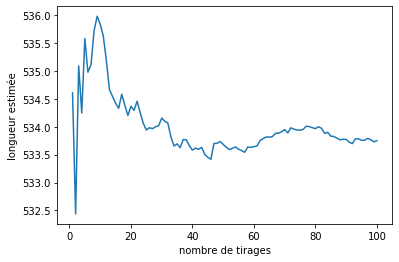

In [119]:
#Question 9
print(longueur_estimee(C_, E_cond_, delta, obs_index, depth, 100))
print(longueur(E_cond_, delta, depth))
"""Les longueurs ne sont pas proches : en effet, la longueur de l'espérance n'est pas l'espérance de la longueur.
Un tel écart est peut être aussi dû au fait qu'on a pris une matrice très simpliste pour vérifier les fonctions : 
la matrice identité"""
#Question 10
def aff_mn(n):
    L = [] 
    s = 0
    for i in range(1, n+1) : 
        s += longueur(tirage(C_, obs_index, non_obs_index, E_cond_), delta, depth)
        L.append(s/(i))
    plt.plot([i for i in range(1, n+1)], L)
    plt.ylabel("longueur estimée")
    plt.xlabel('nombre de tirages')
aff_mn(100)
"""Evidemment, notre calcul de Mn n'est pas optimal : on pourrait rajouter à chaque fois Mn+1 à la liste des longueurs estimées
en rajoutant uniquement un tirage et non pas n+1, cependant pour cela il faudrait écrire un autre programme, et on ne compte
afficher ce graphique un faible nombre de fois, cela n'en vaut pas la peine."""

On observe sans grande surprise que la suite Mn converge lorsque n tend vers $+\infty$ vers une valeur, qui est en réalité la longueur moyenne du cable. 

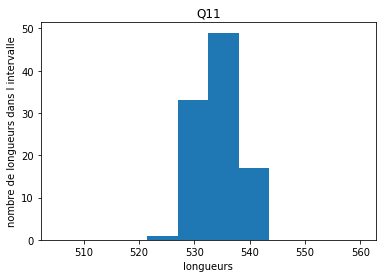

In [120]:
# Question 11 : Histogramme des longueurs avec un tirage
liste_long = [longueur(tirage(C_, obs_index, non_obs_index, E_cond_), delta, depth) for i in range(100)] 
#on pourra remplacer n = 100 par 1000 ou 10000... pour la q14
plt.hist(liste_long, range = (505, 560))
plt.title("Q11")
plt.ylabel('nombre de longueurs dans l intervalle')
plt.xlabel('longueurs')
plt.show()

In [142]:
#Question 12
"""on doit trouver un intervalle encadrant la valeur du cable, tel que la probabilité qu'un tirage soit dans cet intervalle
soit d'au moins 95 %"""
def intervalle_conf_un(C, E_cond, delta, depth, n = 100):
    """ici, on commence par estimer une moyenne, et ensuite on fait baisser diff pour que la probabilité pour
    un essai d'être dans [L-diff, L + diff] soit juste au-dessus de 0.95"""
    L = longueur_estimee(C, E_cond, delta, obs_index, depth, n)#ca serait la longueur moyenne
    def proba(diff):
        s = 0
        for i in range(n):
            if (L-diff <= longueur(tirage(C, obs_index, non_obs_index, E_cond), delta, depth) <= L+diff) : 
                s += 1
        return s/n
    diff = L #c'est l'essai d'intervalle de confiance initial
    while proba(diff) >= 0.95 : #tant que l'on n'est pas inclu dans l'intervalle de confiance
        diff/= 1.1
    return (L-diff*2, L+diff*2)

def intervalle_conf_deux(C, E_cond, delta, depth, n = 100):
    """ici, on calcule directement l'intervalle de confiance avec une formule, après avoir estimé la moyenne ainsi que l'écart-type
    sur l'échantillon"""
    L = longueur_estimee(C, E_cond, delta, obs_index, depth, n)#moyenne
    V = 0
    for i in range(n):
        V += (longueur(tirage(C, obs_index, non_obs_index, E_cond), delta, depth) - L) **2
    sigma = np.sqrt(V/n)#ecart-type
    return (L - 1.96 * sigma/np.sqrt(n), L + 1.96 * sigma/np.sqrt(n))

#Question 13
def prob_depass(l_dep, C, E_cond, delta, depth, n = 100):
    """ici, on fai juste n tirages et on regarde quelle proportion a dépassé 525, 
    on applique la loi des grands nombres à l'indicatrice de l>=525 et on obtient le résultat voulu"""
    s = 0
    for i in range(n):
        if l_dep <= longueur(tirage(C, obs_index, non_obs_index, E_cond), delta, depth) : 
            s += 1
    return s/n
    

In [145]:
#tests question 12 et 13
print(intervalle_conf_un(C_, E_cond_, delta, depth))
"""ce premier calcul d'intervalle de confiance est assez peu précis, et pour cause :
on réduit diff en le divisant à chaque fois par 1.1, ce qui est une forte diminution
pour des valeurs de l'ordre de la dizaine comme dans notre cas"""
print(intervalle_conf_deux(C_, E_cond_, delta, depth))
print(prob_depass(525, C_, E_cond_, delta, depth))
"""ici, c'est intéressant : comme notre loi est gaussienne, toutes les valeurs de R sont possibles, cependant la probabilité estimée
d'être inférieur à 525 est nulle. C'est dû à la faible valeur de n"""


(522.0351327941881, 546.2602076313839)
(532.545586951336, 534.1682269298326)
1.0


"ici, c'est intéressant : comme notre loi est gaussienne, toutes les valeurs de R sont possibles, cependant la probabilité estimée\nd'être inférieur à 525 est nulle. C'est dû à la faible valeur de n"

"on observe ici de manière beaucoup plus visible que la moyenne des tirages tend vers une valeur, \nqui correspond à la longueur moyenne (à peu près 534, c'est d'ailleurs indépendant de la matrice de covariance, \ndonc normalement on a le bon résultat)"

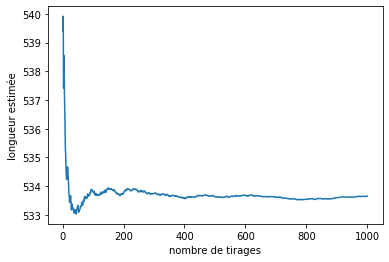

In [146]:
#Question 14
"""pour n=100 ou n=1000, il suffit de faire tourner ces programmes en changeant la valeur par défaut de n, 
qu'on a mis en argument par défaut dans tous les programmes précédents. Cependant, on se contentera de n = 1000 pour des raisons
de temps d'exécution."""
# n = 1000
#Q10
aff_mn(1000)
"""on observe ici de manière beaucoup plus visible que la moyenne des tirages tend vers une valeur, 
qui correspond à la longueur moyenne (à peu près 534, c'est d'ailleurs indépendant de la matrice de covariance, 
donc normalement on a le bon résultat)"""


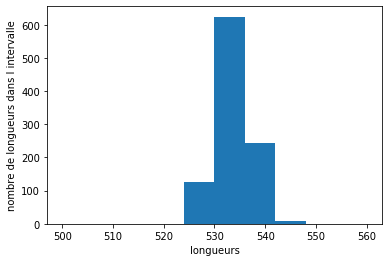

"avec n = 1000, on obtient une bien meilleure approximation par l'histogramme de la gaussienne \n(il suffirait de faire tendre la largeur des rectangles vers 0 en augmentant n et de diviser\nle nombre de longueurs par le nombre total de tirages pour l'obtenir)"

In [147]:
#Q11
liste_long = [longueur(tirage(C_, obs_index, non_obs_index, E_cond_), delta, depth) for i in range(1000)] 
plt.hist(liste_long, range = (500, 560))
plt.ylabel('nombre de longueurs dans l intervalle')
plt.xlabel('longueurs')
plt.show()
"""avec n = 1000, on obtient une bien meilleure approximation par l'histogramme de la gaussienne 
(il suffirait de faire tendre la largeur des rectangles vers 0 en augmentant n et de diviser
le nombre de longueurs par le nombre total de tirages pour l'obtenir)"""

In [149]:
#Q12 et 13
print(intervalle_conf_un(C_, E_cond_, delta, depth, 1000))
print(intervalle_conf_deux(C_, E_cond_, delta, depth, 1000))
"""pour la méthode 1, l'augmentation de n rend uniquement l'estimation de la moyenne plus précise,
le facteur limitant pour cet algorithme est la division par 1.1
pour la seconde la précision de l'algorithme est aussi accrue car n intervient dans les calculs d'espérance et d'écart-type
injectés dans la formule"""
print(prob_depass(525, C_, E_cond_, delta, depth, 1000))
"""Ici encore, l'augmentation de n permet d'augmenter la précision de l'estimation de la probabilité : en effet, on 
améliore ainsi la viabilité de l'utilisation de la loi des grands nombres dans cet algorithme"""

(521.8493813924164, 546.0658364235372)
(533.388123326287, 533.8383478492375)
0.997


"Ici encore, l'augmentation de n permet d'augmenter la précision de l'estimation de la probabilité : en effet, on \naméliore ainsi la viabilité de l'utilisation de la loi des grands nombres dans cet algorithme"